In [1]:
# Bunch of useful libraries + wngrad
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
import torch
from sklearn.datasets import load_svmlight_file
import random
import helpers
%matplotlib inline

# SVM parameters

In [2]:
DATA_TRAIN_PATH = '../labs/ex09/template/data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
n_instances, n_features = A.shape
A = torch.tensor(A, dtype=torch.float, requires_grad = True)
y = torch.tensor(y, dtype=torch.float, requires_grad = True)
print(y.shape, A.shape)

torch.Size([2477]) torch.Size([2477, 300])


## Optimizer

In [27]:
class WNGrad(torch.optim.Optimizer):
  
    def __init__(self, params, lr=1, lambda_=None):

        defaults = dict(lr=lr, lambda_=lambda_)
        super(WNGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(WNGrad, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:# This enables us to re-evaluate the gradient.
            with torch.enable_grad():
                loss = closure() 

        withoutLambda = True
        
        # Iterate groups of parameters (aka layers in NN)
        for group in self.param_groups:
            # Iterate actual parameters in the layers 
            for param in group['params']:
                print(param.grad)
                if param.grad is not None:
                    state = self.state[param]
                    lambda_ = group['lambda_']
                    # Calculate state[b_j] for a first time
                    if len(state) == 0:
                        b_candidates = []
                        # Iterate a few points  
                        for i in np.arange(-3, 3, 0.2):
                            # Change parameters differently
                            sigma = torch.Tensor([10]).pow(-i)
                            params_temp = param + torch.empty_like(param, requires_grad = True).normal_(0, 10**i)
                            params_temp.requires_grad = True
#                             params_temp.grad = torch.autograd.Variable(torch.zeros(1,), requires_grad=True)
                            print(params_temp.requires_grad)
                            loss = closure(alternative_w = params_temp)
#                             loss.requires_grad = True
                            loss.backward()
                            for group in self.param_groups:
                                for param in group['params']:
                                    if param.grad is not None:
                                        print('Hola')
                                        print(params_temp.grad)
                                        b_candidates.append((param.grad-params_temp.grad).norm(2)/(param-params_temp).norm(2))
                        print(b_candidates)
                        state['b_j'] = max(b_candidates)
                        print(f'initial b: ', state['b_j'])

                    lr = 1/state['b_j']
                    if lambda_ is None:
                        #print("Before", param.grad)
                        param.sub_(param.grad, alpha=lr) #add_ is inplace.
                        #print("After sub", param, param.grad)
                    else:
                        # Scaling used (opposite order)
                        withoutLambda = False
                        grad_2_norm = param.grad.pow(2).sum().sqrt()
                        state['b_j'] = lr + (lambda_**2)*grad_2_norm*lr
                        param.sub_(param.grad, alpha=lambda_*lr)
        
        # Re evaluate the gradients so that we can update b_j based on x_t.
        if closure is not None and withoutLambda: 
            with torch.enable_grad():
                _ = closure()
                # Update b_j for each param using gradient eval at x_t
                for group in self.param_groups:
                    for param in group['params']:
                        if param.grad is not None:
                            state = self.state[param]
                            prev_bj = state['b_j']
                            grad_2_norm = param.grad.pow(2).sum()
                            #print("After", param.grad)
                            update = grad_2_norm/prev_bj
                            #print("ratio", ratio)
                            state['b_j'] = prev_bj + update

        return loss

In [36]:
def calculate_primal_objective(y, A, w, lambda_):
    """compute the full cost (the primal objective), that is loss plus regularizer.
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    
    Note - Function designed for PyTorch
    """
    if type(A) == torch.Tensor:
        v = torch.maximum(1 - y * (A @ w), torch.zeros_like(y, requires_grad = True))
        print('v.requires_grad', v.requires_grad)
        loss = torch.sum(v) + lambda_ / 2 * torch.sum(w ** 2)
        
#         print(w.requires_grad)
#         print(loss.requires_grad)
#         loss.requires_grad = True 
        print('Torch')
        return loss
    else:
        v = np.maximum(1 - y * (A @ w), 0)
        return np.sum(v) + lambda_ / 2 * np.sum(w ** 2)

w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)
optimizer = WNGrad([w], lr=None, lambda_=0.01)

def train_SVM(A, b, w, lambda_, nb_of_iter = 5000):
    history = defaultdict(list)
    for i in range(nb_of_iter):
        # 'forward pass'
        output = helpers.prediction(A, w)
        # Calculate loss
        loss = calculate_primal_objective(y, A, w, lambda_)
        loss.backward()
        if i == nb_of_iter/10:
            print(i)
        def closure(alternative_w = None):
            optimizer.zero_grad()
            if alternative_w != None:
                print('Calculating with alternative w')
                output = (A @ alternative_w > 0) * 2 - 1
                print('A grad:', A.requires_grad, 'output grad:', output.requires_grad)
                loss = calculate_primal_objective(y, A, alternative_w, lambda_)
                print(f'Inside closure: y:{y.requires_grad}, A:{A.requires_grad}, \
                      alt_w:{alternative_w.requires_grad}, loss:{loss.requires_grad}')
            else:
                output = (A @ w > 0) * 2 - 1
                loss = calculate_primal_objective(y, A, w, lambda_)
            return loss
        optimizer.zero_grad()
        print('Calling Optimizer Step')
        optimizer.step(closure)
        history['loss'].append(loss)
        
    return history, loss

history, loss = train_SVM(A, y, w, lambda_ = 0.01, nb_of_iter = 5)

v.requires_grad True
Torch
Calling Optimizer Step
v.requires_grad True
Torch
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [21]:
history_sgd_4, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=500, trace=True)
history_sgd_3, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=500, trace=True)
history_sgd_35, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 5e-4, batch_size=500, trace=True)


NameError: name 'stochastic_gradient_descent_svm_demo' is not defined

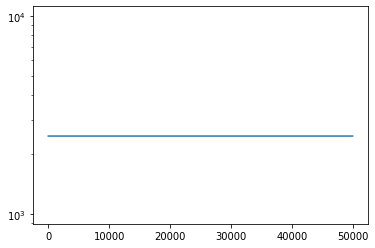

In [7]:
plt.semilogy(range(50000), history["loss"], label="SGD, gamma = 10^{-4}")
# plt.semilogy(history_wngrad["iter"], history_wngrad["objective_function"], label="WNGrad")
# plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="SGD, gamma = 10^{-3}")
# plt.semilogy(history_sgd_35["iter"], history_sgd_35["objective_function"], label="SGD, gamma = 5*10^{-4}")
# plt.legend()

In [11]:
class SVMWNGrad():

    def __init__(self, n_iter=100, lr=None, lambda_=None):
        self.n_iter = n_iter
        self.lr = lr
        self.lambda_ = lambda_
        
    def fit(self, A, y):

        n_instances, n_features = X.shape
        
        # we need to "wrap" the NumPy arrays X and Y as PyTorch tensors
        Xt = torch.tensor(A, dtype=torch.float)
        yt = torch.tensor(y, dtype=torch.float)

        # initialize the weight vector to all zeros
        self.w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)

        self.history = []
        
        # we select an optimizer, in this case (minibatch) SGD.
        # it needs to be told what parameters to optimize, and what learning rate (lr) to use
        optimizer = WNGrad([self.w], lr=self.lr, lambda_=self.lambda_)
        
        svm_loss = helpers.calculate_primal_objective
        # as an alternative to SGD, we could have used adaptive gradient-based optimization
        # algorithms such as Adam. I don't think they give an improvement in this case though,
        # since the objective function is so simple.
        #   optimizer = torch.optim.Adam([self.w], lr=self.eta)
        for i in range(self.n_iter):  
            def closure(alternative_w = None):
                optimizer.zero_grad()
                output = (Xt @ self.w > 0) * 2 - 1
                if alternative_w != None:
                    loss = svm_loss(yt, At, alternative_w, lambda_)
                else:
                    loss = svm_loss(yt, At, alternative_w, lambda_)
                loss.backward()
                return loss

            loss = optimizer.step(closure)
            self.history.append(loss)
                                      
        print('WNGrad final loss: {:.4f}'.format(loss))

defaultdict(dict, {})